In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import why

# Demo on using the "why" library
To estimate the causal effect between any two variables, the following three steps needed to be carried out:
* Causal Discovery to obtain a Structural Causal Model
* Obtain adjustment set for the two variables given the Structural Model from the first step
* Estimate the causal effect
* (Optionally) generate bounds and sensitivity analysis for the estimate

# Step 1: Causal Discovery
The PC algorithm is used to generate a Structural Causal Model

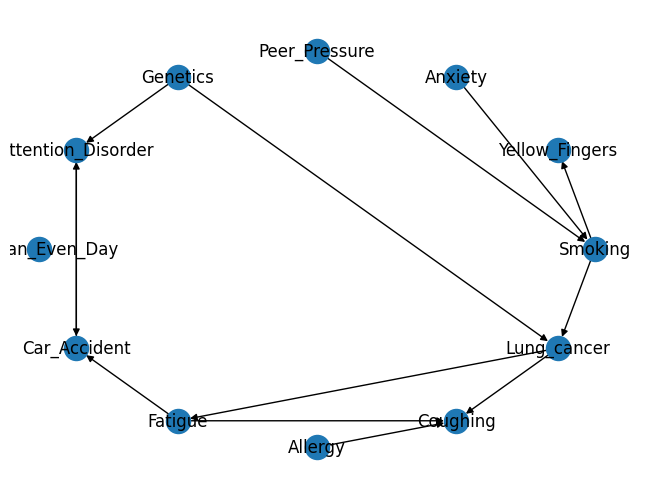

In [2]:
df = pd.read_csv("./data/lucas0_train.csv")

independence_test = why.CausalDiscovery.PearsonsCorrelation(0.05)
PC = why.CausalDiscovery.CausalDiscoveryPC(df, independence_test)

graph = PC.get_networkx_graph(draw=True)

# Step 2: Deduce any missing directions
This can be done using multiple methods:
* GNN (Generative Neural Network)
* Manually

In [3]:
# # using GNN
# gnn = why.CausalDiscovery.GNNOrientation(n_orientation_runs=4, batch_size=500)
# oriented_graph = gnn.orient_edges(graph, df, verbose=True)
# nx.draw_circular(oriented_graph, with_labels=True)

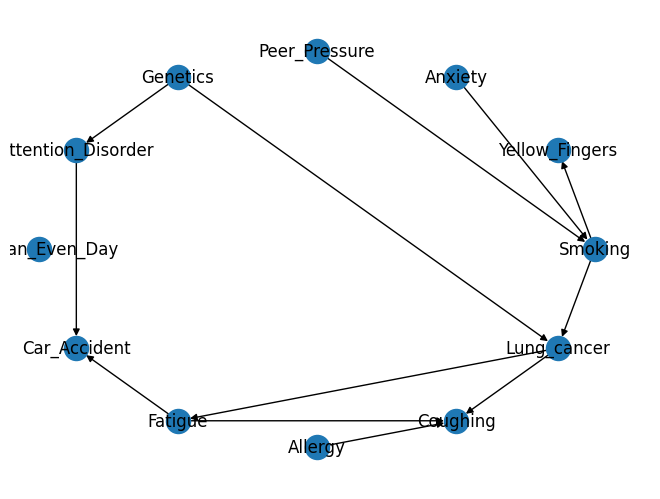

In [4]:
# Manually
ui = why.CausalDiscovery.UIOrientEdges(graph)
ograph = ui.orient_edges()

# Step 2: Backdoor adjustment
Backdoor adjustment is used to derive a minimal sufficient adjustment between any two variables

In [5]:
treatment = "Smoking"
outcome = "Lung_cancer"
adjustor = why.BackdoorAdjustment(ograph)
adjustment_sets = adjustor.get_all_backdoor_adjustment_set(treatment, outcome)
if len(adjustment_sets) == 0:
    print("No causal chain found between {} and {}".format(treatment, outcome))
minimal_adjustment_set = list(adjustment_sets[0])
minimal_adjustment_set

[]

# Step 3: Estimation
Generate an estimate for the causal effect (ATE: Average Treatment Effect) between the two variables using the adjustment set and the data. The following estimators can be used in combination with any statistical estimator:
* COMEstimator
* GCOMEstimator
* TARNet

In [10]:
# COMEstimator with LogisticRegression, SVM
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

class LogisticModel: # The estimator must implement this interface to be used with COMEstimator
    def __init__(self):
        self.model = LogisticRegression()

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict_proba(X)[:, 1]

estimator = why.Estimation.COMEstimator(df, LogisticModel())
com_logistic_ate = estimator.estimate(treatment, outcome, minimal_adjustment_set)
print(f"COM Logistic ATE: {com_logistic_ate:.4f}")

class SVMModel:
    def __init__(self):
        self.model = SVC(probability=True)

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict_proba(X)[:, 1]
estimator = why.Estimation.COMEstimator(df, SVMModel())
com_svm_ate = estimator.estimate(treatment, outcome, minimal_adjustment_set)
print(f"COM SVM ATE: {com_svm_ate:.4f}")

COM Logistic ATE: 0.5041
COM SVM ATE: 0.5064


In [14]:
# GCOMEstimator with LogisticRegression, SVM
print("Empty Adjustment Set")
estimator = why.Estimation.GCOMEstimator(df, LogisticModel())
gcom_logistic_ate = estimator.estimate(treatment, outcome, minimal_adjustment_set)
print(f"GCOM Logistic ATE: {gcom_logistic_ate:.4f}")

estimator = why.Estimation.GCOMEstimator(df, SVMModel())
gcom_svm_ate = estimator.estimate(treatment, outcome, minimal_adjustment_set)
print(f"GCOM SVM ATE: {gcom_svm_ate:.4f}")

print("With an Adjustment Set")
estimator = why.Estimation.GCOMEstimator(df, LogisticModel())
gcom_logistic_ate = estimator.estimate(treatment, outcome, list(adjustment_sets[1]))
print(f"GCOM Logistic ATE: {gcom_logistic_ate:.4f}")

estimator = why.Estimation.GCOMEstimator(df, SVMModel())
gcom_svm_ate = estimator.estimate(treatment, outcome, list(adjustment_sets[1]))
print(f"GCOM SVM ATE: {gcom_svm_ate:.4f}")

Empty Adjustment Set
Warning, GCOM: No adjustment set provided, returning ate = E[Y|T=1]-E[Y|T=0]
GCOM Logistic ATE: 0.5105
Warning, GCOM: No adjustment set provided, returning ate = E[Y|T=1]-E[Y|T=0]
GCOM SVM ATE: 0.5105
With an Adjustment Set
GCOM Logistic ATE: 0.5131
GCOM SVM ATE: 0.5076


In [18]:
# TARNet
estimator = why.Estimation.TARNet(df)
tarnet_no_adj_set = estimator.estimate(treatment, outcome, minimal_adjustment_set)
print(f"No adj set TARNet ATE: {tarnet_no_adj_set:.4f}")

estimator = why.Estimation.TARNet(df)
tarnet_with_adj_set = estimator.estimate(treatment, outcome, list(adjustment_sets[1]))
print(f"With adj set TARNet ATE: {tarnet_with_adj_set:.4f}")

Warning, GCOM: No adjustment set provided, returning ate = E[Y|T=1]-E[Y|T=0]
No adj set TARNet ATE: 0.5105
With adj set TARNet ATE: 0.5104


# Step 4.1: Bounds

In [15]:
assumptions = [why.Bounds.OptimalTreatmentSelection, why.Bounds.MonotoneTreatmentSelection]
bounds = why.BoundsEstimator(df)
bounds.compute_bound(treatment, outcome, assumptions)

(0.3006262626262625, 0.5104667941877243)

# Step 4.2: Sensitivity Analysis

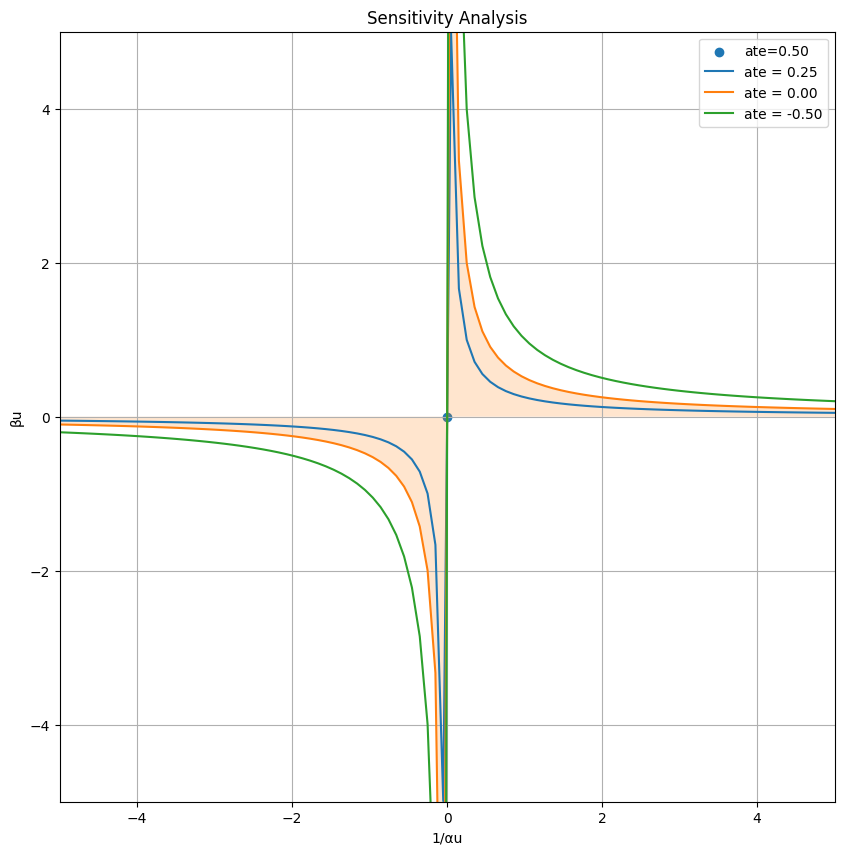

In [16]:
sensitivity_analysis = why.SensitivityAnalysis.LinearSingleConfounder(df)
plt.figure(figsize=(10,10))
plt.title("Sensitivity Analysis")
sensitivity_analysis.sensitivity_contour(com_logistic_ate, x_ranges=[-5, 5], y_ranges=[-5, 5], region_range=[0, com_logistic_ate])
plt.show()

# Evaluation using ground truth
